# Imports

In [1]:
! git clone https://github.com/Horea94/Fruit-Images-Dataset.git

import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from glob import glob

from utils import *
from classes import *

Cloning into 'Fruit-Images-Dataset'...
remote: Enumerating objects: 5796, done.
remote: Counting objects: 100% (5796/5796), done.
remote: Compressing objects: 100% (5773/5773), done.
remote: Total 365875 (delta 39), reused 5764 (delta 23), pack-reused 360079
Receiving objects: 100% (365875/365875), 2.02 GiB | 28.32 MiB/s, done.
Resolving deltas: 100% (1044/1044), done.
Checking out files: 100% (71140/71140), done.


# Device Selection

In [2]:
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)


# Reproducibility
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(1)


if not os.path.exists('./model'):
    os.makedirs('./model')

cuda:0


# Create data sets and loaders

Number of images in Training file: 53177
class             Count:
------------------------
Apple Red 1          492
Strawberry           492
Kohlrabi             471
Pineapple            490
Pear Kaiser          300
Grapefruit White     492
Apricot              492
Strawberry Wedge     738
Kumquats             490
Pear Abate           490
Cherry Wax Red       492
Lychee               490
Cherry Wax Yellow    492
Pineapple Mini       493
Kiwi                 466
Mulberry             492
Plum                 447
Grape Pink           492
Cherry 1             492
Apple Golden 1       492
Limes                490
Physalis with Husk   492
Hazelnut             464
Walnut               735
Guava                490
Melon Piel de Sapo   738
Cactus fruit         490
Pear                 492
Pear Monster         490
Lemon Meyer          490
Pitahaya Red         490
Tangelo              490
Cocos                490
Apple Red Yellow 1   492
Quince               490
Granadilla           490
Lemon    

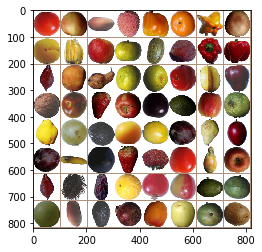

['Tomato Cherry Red', 'Apple Red 2', 'Hazelnut', 'Lychee', 'Pepper Yellow', 'Tomato Yellow', 'Carambula', 'Apple Red 3', 'Peach 2', 'Physalis with Husk', 'Apple Red Yellow 1', 'Pomelo Sweetie', 'Melon Piel de Sapo', 'Salak', 'Pepper Red', 'Pepper Red', 'Salak', 'Peach', 'Pear Abate', 'Pomelo Sweetie', 'Pomelo Sweetie', 'Tomato 2', 'Carambula', 'Apple Red Delicious', 'Walnut', 'Tomato Maroon', 'Strawberry', 'Apple Braeburn', 'Cherry Wax Black', 'Avocado', 'Apple Pink Lady', 'Limes', 'Quince', 'Grape White', 'Avocado ripe', 'Cherry Wax Yellow', 'Maracuja', 'Plum', 'Pear Williams', 'Tamarillo', 'Plum', 'Banana', 'Grape Blue', 'Strawberry', 'Strawberry Wedge', 'Tomato Cherry Red', 'Cactus fruit', 'Apple Pink Lady', 'Salak', 'Rambutan', 'Dates', 'Cantaloupe 1', 'Redcurrant', 'Cherry Rainier', 'Avocado', 'Mango', 'Grape White 4', 'Hazelnut', 'Avocado ripe', 'Mangostan', 'Apricot', 'Apple Golden 2', 'Mango', 'Kiwi']


In [3]:
path = './Fruit-Images-Dataset'

files_training = glob(os.path.join(path,'Training', '*/*.jpg'))
num_images = len(files_training)
print('Number of images in Training file:', num_images)

min_images = 1000
im_cnt = []
class_names = []
print('{:18s}'.format('class'), end='')
print('Count:')
print('-' * 24)
for folder in os.listdir(os.path.join(path, 'Training')):
    folder_num = len(os.listdir(os.path.join(path, 'Training', folder)))
    im_cnt.append(folder_num)
    class_names.append(folder)
    print('{:20s}'.format(folder), end=' ')
    print(folder_num)
    if folder_num < min_images:
        min_images = folder_num
        folder_name = folder

num_classes = len(class_names)
print("\nMinumum imgages per category:", min_images, 'Category:', folder)
print('Average number of Images per Category: {:.0f}'.format(np.array(im_cnt).mean()))
print('Total number of classes: {}'.format(num_classes))

tensor_transform = transforms.Compose([transforms.ToTensor()])

all_data = ImageFolder(os.path.join(path, 'Training'), tensor_transform)
data_loader = torch.utils.data.DataLoader(all_data, batch_size=512, shuffle=True)
pop_mean = []
pop_std = []

for i, data in enumerate(data_loader, 0):
    numpy_image = data[0].numpy()

    batch_mean = np.mean(numpy_image, axis=(0, 2, 3))
    batch_std = np.std(numpy_image, axis=(0, 2, 3))

    pop_mean.append(batch_mean)
    pop_std.append(batch_std)

pop_mean = np.array(pop_mean).mean(axis=0)
pop_std = np.array(pop_std).mean(axis=0)

print(pop_mean)
print(pop_std)

np.random.seed(123)
shuffle = np.random.permutation(num_images)
split_val = int(num_images * 0.2)
print('Total number of images:', num_images)
print('Number of valid images after split:', len(shuffle[:split_val]))
print('Number of train images after split:', len(shuffle[split_val:]))

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(pop_mean, pop_std)
        # These were the mean and standard deviations that we calculated earlier.
    ]),
    'Test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(pop_mean, pop_std)
        # These were the mean and standard deviations that we calculated earlier.
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(pop_mean, pop_std)
        # These were the mean and standard deviations that we calculated earlier.
    ])
}

train_dataset = FruitTrainDataset(files_training, shuffle, split_val, class_names, data_transforms['train'])
valid_dataset = FruitValidDataset(files_training, shuffle, split_val, class_names, data_transforms['valid'])
test_dataset = FruitTestDataset(path+'/Test', class_names, transform=data_transforms['Test'])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)
# These are just used for convinience purposes

dataloaders = {'train': train_loader,
               'valid': valid_loader,
               'Test': test_loader}
dataset_sizes = {
    'train': len(train_dataset),
    'valid': len(valid_dataset),
    'Test': len(test_dataset)
}

# Here we are just checking out the next batch of images from the train_loader, and below I print the class names.
inputs, classes = next(iter(train_loader))
out = make_grid(inputs)

cats = ['' for x in range(len(classes))]
for i in range(len(classes)):
    cats[i] = class_names[classes[i].item()]

imshow(out, pop_mean, pop_std)
print(cats)

# DCGAN

## Define DCGAN

In [4]:
batch_size = 64
num_epochs = 20
learning_rate = 1e-3
latent_vector_size = 1800

use_weights_init = True

model_G = Generator(latent_vector_size).to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
print("Total number of parameters in Generator is: {:,}".format(params_G))
print(model_G)
print('\n')

model_D = Discriminator(50).to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
print("Total number of parameters in Discriminator is: {:,}".format(params_D))
print(model_D)
print('\n')
print("Total number of parameters is: {:,}".format(params_G + params_D))


# Define loss function
criterion = nn.BCELoss(reduction='mean')


def loss_function(out, label):
    loss = criterion(out, label)
    return loss


# Choose and initialize optimizers
beta1 = 0.5
optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate, betas=(beta1, 0.999))


# Define fixed input vectors to monitor training and mode collapse.
fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
real_label = 1
fake_label = 0

Total number of parameters in Generator is: 58,406,918
Generator(
  (tconv1): ConvTranspose2d(1800, 900, kernel_size=(5, 5), stride=(1, 1))
  (conv1): Conv2d(900, 900, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchn1): BatchNorm2d(900, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(900, 450, kernel_size=(4, 4), stride=(2, 2))
  (conv2): Conv2d(450, 450, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchn2): BatchNorm2d(450, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(450, 225, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(225, 225, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchn3): BatchNorm2d(225, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convc): Conv2d(225, 112, kernel_size=(2, 2), stride=(1, 1))
  (tconv4): ConvTranspose2d(112, 56, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(56, 56, kernel_size=(3, 3)

## Train

In [0]:
# Train
export_folder = './model'
train_losses_G = []
train_losses_D = []

for epoch in range(num_epochs):
    for i, data in enumerate(train_loader, 0):
        train_loss_D = 0
        train_loss_G = 0

        # Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        # train with real
        model_D.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = model_D(real_cpu)
        errD_real = loss_function(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
        fake = model_G(noise)
        label.fill_(fake_label)
        output = model_D(fake.detach())
        errD_fake = loss_function(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        train_loss_D += errD.item()
        optimizerD.step()

        # Update G network: maximize log(D(G(z)))
        model_G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = model_D(fake)
        errG = loss_function(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        train_loss_G += errG.item()
        optimizerG.step()

    if epoch == 0:
        save_image(denorm(real_cpu.cpu()), './model/real_samples.png')

    fake = model_G(fixed_noise)
    save_image(denorm(fake.cpu()), './model/fake_samples_epoch_%03d.png' % epoch)
    train_losses_D.append(train_loss_D / len(train_loader))
    train_losses_G.append(train_loss_G / len(train_loader))

    print('[%d/%d] Loss_D: %.4f, Loss_G: %.4f' % (epoch+1, num_epochs, errD.item(), errG.item()))

# save losses and models
np.save('./model/train_losses_D.npy', np.array(train_losses_D))
np.save('./model/train_losses_G.npy', np.array(train_losses_G))
torch.save(model_G.state_dict(), './model/DCGAN_model_G.pth')
torch.save(model_D.state_dict(), './model/DCGAN_model_D.pth')

[1/20] Loss_D: 0.1959, Loss_G: 2.2419
[2/20] Loss_D: 0.0399, Loss_G: 4.3967
[3/20] Loss_D: 0.0155, Loss_G: 4.5228


## Test

In [0]:
# Generator samples
sample_inputs, _ = next(iter(test_loader))
fixed_input = sample_inputs[0:12, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=4, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
show(img)
plt.show()

# load the model
model_G.load_state_dict(torch.load('./model/DCGAN_model_G.pth'))
input_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)

with torch.no_grad():
    # visualize the generated images
    generated = model_G(input_noise).cpu()
    generated = make_grid(denorm(generated)[:12], nrow=4, padding=2, normalize=False,
                          range=None, scale_each=False, pad_value=0)
    show(generated)
    plt.show()


# Train losses curves
train_losses_D = np.load('./model/train_losses_D.npy')
train_losses_G = np.load('./model/train_losses_G.npy')
plt.plot(list(range(0, train_losses_D.shape[0])), train_losses_D, label='loss_D')
plt.plot(list(range(0, train_losses_G.shape[0])), train_losses_G, label='loss_G')
plt.legend()
plt.title('Train Losses')
plt.show()
